# Four Guys DSGP 

## Question
How to automatically switch notification mode on mobile phone by using sensory data collected from smartphone and smartwatch？

## Data Source
http://extrasensory.ucsd.edu

Publicly available: everyone is invited to download the dataset for free and use it (conditioned on citing our original paper).

## Data Preprocessing

### Functions

In [1]:
import numpy as np
import gzip
import pandas as pd
from sklearn.impute import KNNImputer 
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random

#### parse_header_of_csv

This method take a dataframe as input, return the feature part and label part

In [2]:
def parse_header_of_csv(csv_df):
    # Isolate the headline columns:

    for (ci,col) in enumerate(csv_df.columns):
        # find the start of label column
            if col.startswith('label:'):
                first_label_ind = ci
                break
            pass
    # use the "start of label" find above to split feature and label
    feature_names = csv_df.columns[1:first_label_ind]
    label_names = list(csv_df.columns[first_label_ind:-1])

    # remove "label: " get pure label name
    for (li,label) in enumerate(label_names):
    # In the CSV the label names appear with prefix 'label:', but we don't need it after reading the data:
            assert label.startswith('label:')
            label_names[li] = label.replace('label:','')
            pass

    csv_df.rename(columns=dict(zip(csv_df.columns[first_label_ind:-1],label_names)),inplace=True)
        
    return (feature_names,label_names)

#### parse_body_of_csv

This method take a dataframe and number of features as input, return sensor matrix, label matrix, missing label matrix and timestamp matrix(index)

In [3]:
def parse_body_of_csv(csv_df,n_features):


    # Read the entire CSV body into a single numeric matrix:
    
    # Timestamp is the primary key for the records (examples):
    timestamps = csv_df.index
    # Read the sensor features:
    X = csv_df[csv_df.columns[0:n_features+1]]
    # Read the binary label values, and the 'missing label' indicators:
    trinary_labels_mat = csv_df[csv_df.columns[n_features+1:-1]] # This should have values of either 0., 1. or NaN

    M = pd.isna(trinary_labels_mat) # M is the missing label matrix
    Y = np.where(M,0,trinary_labels_mat) > 0. # Y is the label matrix

    
    return (X,Y,M,timestamps)

#### read_user_data

Read the data (precomputed sensor-features and labels) for a user.

This function assumes the user's data file is present.

this method take id of subject as input
return sensor matrix, label matrix, missing label matrix and timestamp matrix(index) by calling parse_body_of_csv()method

In [4]:
def read_user_data(uuid):
    user_data_file = 'Datasets/%s.features_labels.csv.gz' % uuid

    with gzip.open(user_data_file,'rb') as fid:
        csv_df = pd.read_csv(fid,delimiter=',', index_col= 0)
        pass

    (feature_names,label_names) = parse_header_of_csv(csv_df)
    n_features = len(feature_names)
    (X,Y,M,timestamps) = parse_body_of_csv(csv_df,n_features)

    return (X,Y,M,timestamps,feature_names,label_names)

#### get_df_list

by calling this method we can get a list of dataframe which contain all the user's sensor data

3.6 v0 may get label lists later w.

Author chen

In [5]:
def get_df_list():
    #To create uuid_list which includes all uuid
    uuid_list = []
    f = open('UUID List.txt', 'r')
    for line in f.readlines():
        uuid_list.append(line.strip())

    main_feature = []
    f = open('Main Feature.txt', 'r')
    for line in f.readlines():
        main_feature.append(line.strip())

    instance = []
    # Run all uuid
    for i in range(len(uuid_list)):    
        (X,Y,M,timestamps,feature_names,label_names) = read_user_data(uuid_list[i])

        # Create dataframe for all Main Feature value
        Main_X = pd.DataFrame(X.loc[:,X.columns.str.startswith(main_feature[0])], columns = [main_feature[0]])
        for j in range(1,len(main_feature)):
            Main_X = pd.concat([Main_X, X.loc[:,X.columns.str.startswith(main_feature[j])]], axis=1)
        instance.append(Main_X)
    return instance

#### get_df

For getting single user data to dataframe.

In [6]:
def get_df(uuid):
    main_feature = []
    f = open('Main Feature.txt', 'r')
    for line in f.readlines():
        main_feature.append(line.strip())

    # Run all uuid 
    (X,Y,M,timestamps,feature_names,label_names) = read_user_data(uuid)

    # Create dataframe for all Main Feature value
    Main_X = pd.DataFrame(X.loc[:,X.columns.str.startswith(main_feature[0])], columns = [main_feature[0]])
    for j in range(1,len(main_feature)):
        Main_X = pd.concat([Main_X, X.loc[:,X.columns.str.startswith(main_feature[j])]], axis=1)
    return Main_X

#### data_imputer

by calling these two methods we can fill the null values of feature data.
1. $non\_ watch\_ value\_ imputer$ is use the mean value to fill the feature data from sensors except watch sensors.
2. $KNN\_ for \_ watch \_ data$ is use K nearest neighour to fill the feature data from watch.

In [7]:
def non_watch_value_imputer(df):
    # get the data except watch
    non_watch_values = df.loc[:,(df.columns.str.startswith('watch_') == False)]
    valid_data = pd.DataFrame(columns = ['blank'])
    # use mean values to fill the none value
    for column in non_watch_values.columns:
        column_df = non_watch_values[column]
        mean_value = non_watch_values[column].mean()
        column_df = column_df.fillna(mean_value)
        valid_data = pd.concat([valid_data, column_df],axis=1,ignore_index=False)

    valid_data = valid_data[valid_data.columns[1:]]
    #combine the watch data
    combine_data = pd.concat([valid_data,df.loc[:,df.columns.str.startswith('watch_')]],axis=1,ignore_index=False)
    return combine_data

def KNN_for_watch_data(df,K):
    #input data and K neighbors
    imputer = KNNImputer(n_neighbors=K)
    df[list(df.columns)] = imputer.fit_transform(df)
    return df 

#### pca_to_train_test

by calling this function, PCA can be applied to the pre-cleaned and splitted data.

return the processed data and pca components.

In [8]:
def pca_to_data(csv_df,n):

    pca = PCA(n_components=n)
    features = csv_df.loc[:,csv_df.columns.str.startswith('audio_naive')]
    new_features = pca.fit_transform(features)
    pca_components = pca.components_

    print('PCA explained variance ratio is', pca.explained_variance_ratio_.sum())

    new_feature_df = pd.DataFrame(data=new_features,index=csv_df.index,columns=['audio_naive:pc1','audio_naive:pc2'])
    other_features = csv_df.loc[:,(csv_df.columns.str.startswith('audio_naive') == False)]
    new_feature_df = pd.concat([other_features,new_feature_df],axis=1,ignore_index=False)


    return (new_feature_df, pca_components)

def pca_to_train_test(X_train, X_test, data):
    
    X_train = pd.DataFrame(X_train,columns=data.iloc[:,:-1].columns)
    X_test = pd.DataFrame(X_test,columns=data.iloc[:,:-1].columns)
    X_train_pca, projection = pca_to_data(X_train,2)

    audio_test = X_test.loc[:,X_test.columns.str.startswith('audio_naive')]
    X_test_pca = X_test.loc[:,X_test.columns.str.startswith('audio_naive')==False]
    projection_matrix = pd.DataFrame(np.dot(audio_test,projection.T),columns=['audio_naive:pc1','audio_naive:pc2'])
    X_test_pca = pd.concat([X_test_pca,projection_matrix],axis=1)
    return X_train_pca.values, X_test_pca.values

#### get_related_label

by calling this function, input wanted label 

return counts of this label (For EDA)

In [9]:
def get_related_label(char):
    with gzip.open('cleaned_data.zip','rb') as data:
        data = pd.read_csv(data,index_col=[0,1])
    new_label_data = []
    for uuid in data.groupby('uuid').count().index:
        X,Y,M,timestamps,feature_names,label_names = read_user_data(uuid)
        label_dict = {v: k for k, v in dict(enumerate(label_names + ['None'])).items()}
        label_list = []
        for each in Y:
            if np.array(each).any()==False:
                continue
            else:
                new_label_names = np.array(label_names)[each]
                if char in new_label_names:
                    label_list.append(list(new_label_names))
    new_label_data = new_label_data + label_list
    labels = []
    for i in new_label_data:
        labels = labels + i
    l_dict = {}
    for key in labels:
        l_dict[key] = l_dict.get(key, 0) + 1
    return l_dict


#### splitdata

by calling this function, input dataframe and split ratio

return four datasets, train_data_x, test_data_x, train_data_y, test_data_y.

In [10]:
def splitdata(Final_data,test_size):
    with gzip.open('cleaned_data.zip','rb') as data:
        data = pd.read_csv(data,index_col=[0,1])
    idlist = data.groupby('uuid').count().index
    stamps_index = {}
    for id in idlist:
        length = len(Final_data.loc[id])
        random.seed(777)
        stamps_index[id] = random.sample(range(0,length),int(length*test_size))

    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for k, v in stamps_index.items():
        test_data = pd.concat([test_data, Final_data.loc[k].iloc[v]], axis = 0)
        
        total = Final_data.loc[k]
        remain = total[~total.isin(Final_data.loc[k].iloc[v])].dropna()
        
        train_data = pd.concat([train_data, remain], axis = 0)
    
    # Prepare training data X and Y
    train_data_x = train_data.iloc[:,:-1].values
    train_data_y = train_data.iloc[:,-1].values.astype(int)

    # Prepare testing data X and Y
    test_data_x = test_data.iloc[:,:-1].values
    test_data_y = test_data.iloc[:,-1].values.astype(int)

    return train_data_x, test_data_x, train_data_y, test_data_y

#### TS_split

    A method to create X and Y matrix from a time series array for the training of Time series model
    Input:
    ts should be np.array
    lag is number of lags (timestamps back) to use for models
    n_ahead is steps ahead to forecast

    Output is tuple

In [11]:
def TS_data(ts, lag, n_ahead, target_index=-1):
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

def TS_split(Final_data, lag, n_ahead):
    import random
    with gzip.open('cleaned_data.zip','rb') as data:
        data = pd.read_csv(data,index_col=[0,1])
    idlist = data.groupby('uuid').count().index

    random.seed(505)
    randid = random.sample(list(range(0,len(idlist))), len(idlist))

    train_data = pd.DataFrame()
    validation_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for i in randid[0:38]:
        train_data = pd.concat([train_data, Final_data.loc[idlist[i]]], axis = 0)
        
    for i in randid[38:45]:
        validation_data = pd.concat([validation_data, Final_data.loc[idlist[i]]], axis = 0)

    for i in randid[45:]:
        test_data = pd.concat([test_data, Final_data.loc[idlist[i]]], axis = 0)
    
    
    x_train, y_train = TS_data(train_data.values, lag, n_ahead)
    
    x_val, y_val = TS_data(validation_data.values, lag, n_ahead)
    
    x_test, y_test = TS_data(test_data.values, lag, n_ahead)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

### Data cleaning


In [12]:
uuid_list = []
f = open('UUID List.txt', 'r')
for line in f.readlines():
    uuid_list.append(line.strip())
valid_data = pd.DataFrame()
for uuid in uuid_list:
    df = get_df(uuid)
    try:
        cleaned_data = non_watch_value_imputer(df)
        cleaned_data = KNN_for_watch_data(cleaned_data,10)
        muti_index = pd.MultiIndex.from_product([[uuid], cleaned_data.index], names=['uuid','timestamps'])
        cleaned_data = pd.DataFrame(cleaned_data.values, columns=cleaned_data.columns, index=muti_index)
        valid_data = pd.concat([valid_data,cleaned_data],axis=0,ignore_index=False)
    except:
        print(uuid,'failed to export')
valid_data.to_csv('cleaned_data.zip',mode = 'w',compression= 'gzip')

40E170A7-607B-4578-AF04-F021C3B0384A failed to export
61359772-D8D8-480D-B623-7C636EAD0C81 failed to export
61976C24-1C50-4355-9C49-AAE44A7D09F6 failed to export
7D9BB102-A612-4E2A-8E22-3159752F55D8 failed to export
CCAF77F0-FABB-4F2F-9E24-D56AD0C5A82F failed to export
ECECC2AB-D32F-4F90-B74C-E12A1C69BBE2 failed to export
F50235E0-DD67-4F2A-B00B-1F31ADA998B9 failed to export
FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF failed to export


In [13]:
with gzip.open('cleaned_data.zip','rb') as data:
    data = pd.read_csv(data,index_col=[0,1])
main_label_list = [['SLEEPING'],
                   ['LAB_WORK', 'IN_CLASS', 'IN_A_MEETING', 'LOC_main_workplace','COMPUTER_WORK','AT_SCHOOL', 'WITH_CO-WORKERS'],
                   ['FIX_walking', 'FIX_running', 'BICYCLING','OR_exercise'],
                   ['COOKING', 'BATHING_-_SHOWER', 'CLEANING', 'DOING_LAUNDRY', 'WASHING_DISHES', 'TOILET', 'GROOMING', 'DRESSING','EATING'],
                   ['FIX_restaurant','SHOPPING', 'STROLLING', 'DRINKING__ALCOHOL_','WATCHING_TV', 'SURFING_THE_INTERNET', 'AT_A_PARTY', 'AT_A_BAR', 'LOC_beach', 'SINGING', 'WITH_FRIENDS'],                   
                   ['IN_A_CAR', 'ON_A_BUS', 'DRIVE_-_I_M_THE_DRIVER', 'DRIVE_-_I_M_A_PASSENGER','STAIRS_-_GOING_DOWN', 'ELEVATOR']]

new_label_list = ['sleep','efficiency','exercise','life_activity','entertainment','on_the_way']
new_label_dict = {'sleep':0, 'efficiency':1, 'exercise':2, 'life_activity':3, 'entertainment':4, 'on_the_way':5, 'Normal':6}
all_label_list = []

for i in main_label_list:
    all_label_list = all_label_list + i

new_label_data = pd.DataFrame()
for uuid in data.groupby('uuid').count().index:
    X,Y,M,timestamps,feature_names,label_names = read_user_data(uuid)
    label_pair = pd.DataFrame(
        columns = ['Label Name'],
        index = timestamps
    )
    s = Y.shape


    for i in range(0,s[0]): #跑每個timestamps
        arr = np.where(Y[i]==1) #尋找這個timestamp 哪些label是ture
        temp = []
        for j in arr[0]:
            temp.append(label_names[j]) #將這個timestamp true的label name拼成list
        label_pair.loc[timestamps[i], 'Label Name'] = temp #把list放進對應的dataframe位置

    new_label = []
    new_index = []
    for index in label_pair.index:
        label = label_pair.loc[index].values[0]
        if bool(label) == True:
            for num,status in enumerate(main_label_list):
                if bool(set(status) & set(label)):
                    new_label.append(num)
                    new_index.append(index)
                    break
                elif bool(set(label) & set(all_label_list)):
                    continue
                else:
                    new_label.append(new_label_dict['Normal'])
                    new_index.append(index)
                    break 

    muti_index = pd.MultiIndex.from_product([[uuid], new_index], names=['uuid','timestamps'])
    new_label = pd.DataFrame(data = new_label, index = muti_index,columns = ['Status'])
    new_label_data = pd.concat([new_label_data,new_label],axis=0,ignore_index=False)

new_label_data.to_csv('new_label_data.zip',mode = 'w',compression= 'gzip')

## EDA

In [14]:
import seaborn as sns  
sns.set_style('whitegrid') 

In [15]:
with gzip.open('cleaned_data.zip','rb') as file:
    feature_data = pd.read_csv(file,index_col=[0,1])

with gzip.open('new_label_data.zip','rb') as file:
    new_label_data = pd.read_csv(file,index_col=[0,1])

data = pd.concat([feature_data,new_label_data],join='inner',ignore_index=False,axis=1)

### pie chart of labels

[76307 76282 59461 26862 21555 21197  9891]


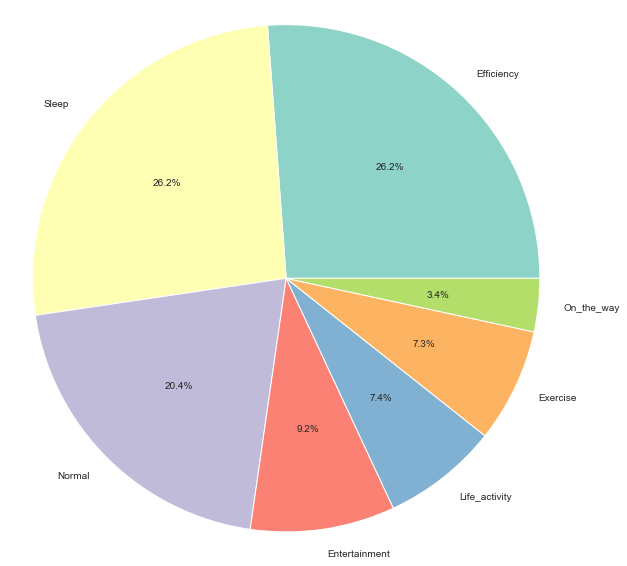

In [16]:
with gzip.open('cleaned_data.zip','rb') as file:
    feature_data = pd.read_csv(file,index_col=[0,1])

with gzip.open('new_label_data.zip','rb') as file:
    new_label_data = pd.read_csv(file,index_col=[0,1])

data = pd.concat([feature_data,new_label_data],join='inner',ignore_index=False,axis=1)

new_label_pair = data.iloc[:,-1].value_counts().index
new_label_count = data.iloc[:,-1].value_counts().values

new_label_dict = {0:'Sleep', 1:'Efficiency', 2:'Exercise', 3:'Life_activity', 4:'Entertainment', 5:'On_the_way', 6:'Normal'}
new_label_pair = [new_label_dict.get(i) for i in new_label_pair]

print(new_label_count)
plt.figure(figsize=(10,10))
plt.pie(new_label_count,labels = new_label_pair, autopct = '%.1f%%')
plt.rcParams.update({"font.size":20})
plt.axis('equal')
plt.show()

### data distribution & time series

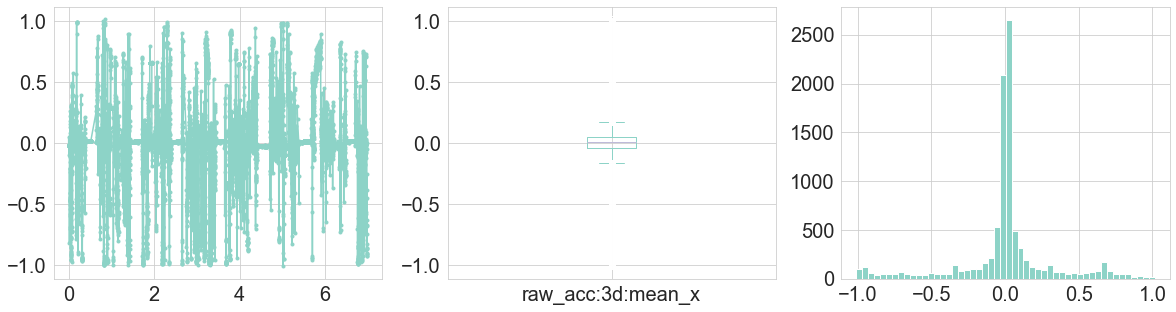

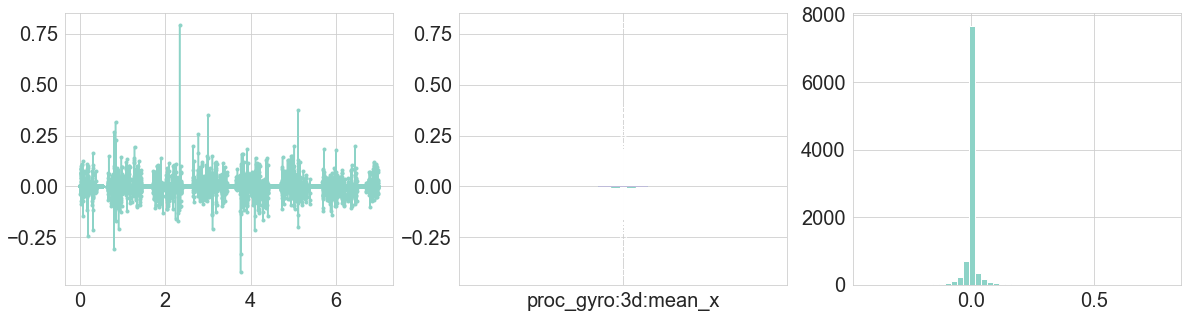

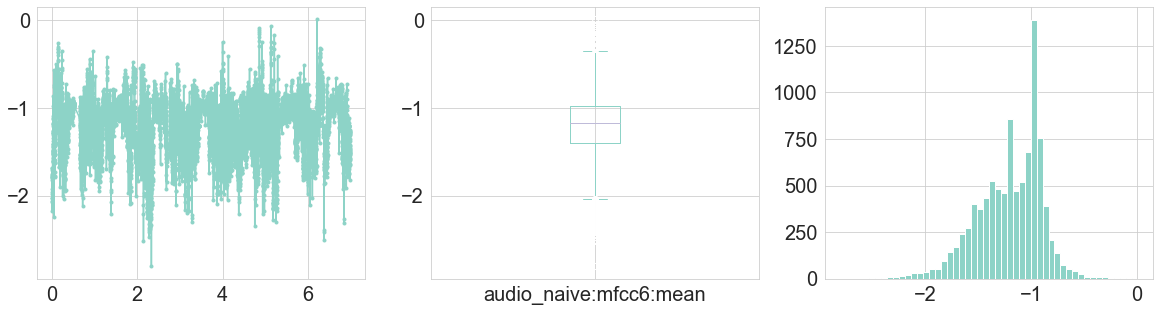

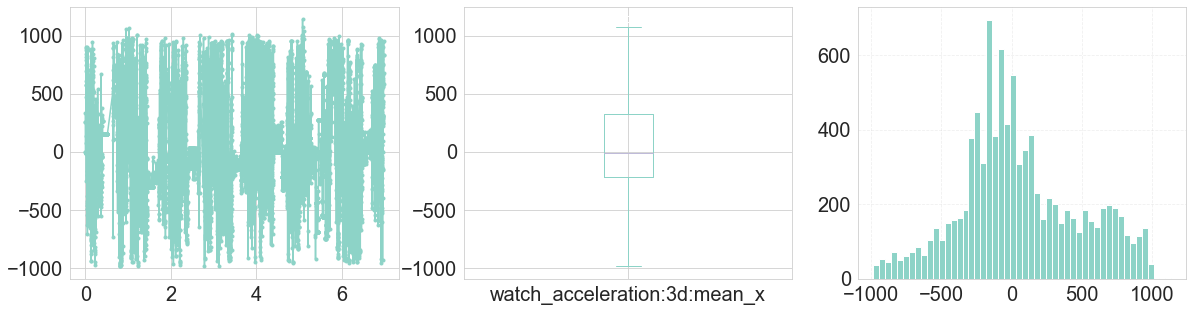

In [17]:
uuid = data.groupby('uuid').count().index[36]
timestamps = data.loc[uuid].index.values
values = data.loc[uuid].iloc[:,:-1]
daytimes = []
for time in timestamps:
    daytimes.append((time - timestamps[0])/float(60*60*24))

feature_number = len(values.columns)
feature_list = [1,5,18,47]
for i in feature_list:
    feature_value = values[values.columns[i]]
    fig = plt.figure(figsize=(20,5))
    ax1 = plt.subplot(1,3,1)
    ax1.plot(daytimes,feature_value,'.-')
    ax2 = plt.subplot(1,3,2)
    feature_value.plot.box()
    ax3 = plt.subplot(1,3,3)
    ax3.hist(feature_value,bins = 50)
plt.grid(linestyle = "--", alpha=0.3)

plt.show()
#print(values.describe())

### Relative Position data from Accelerometer

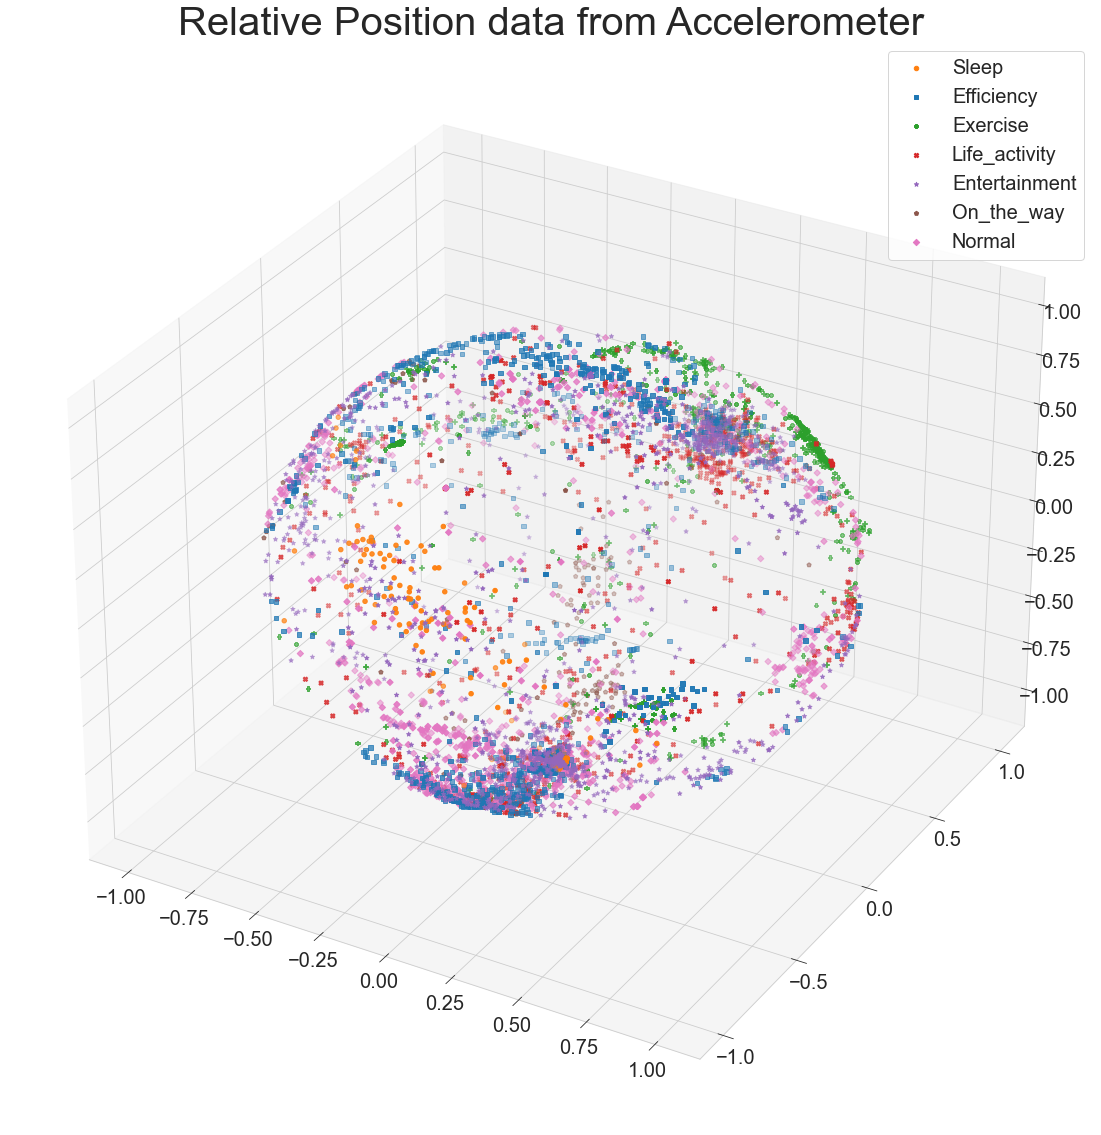

In [18]:
uuid_data = data.loc[uuid]
acc = uuid_data.iloc[:,1:4]
label = uuid_data.iloc[:,-1]
label_type = uuid_data.iloc[:,-1].value_counts().index


new_label_dict = {0:'Sleep', 1:'Efficiency', 2:'Exercise', 3:'Life_activity', 4:'Entertainment', 5:'On_the_way', 6:'Normal'}


fig = plt.figure(figsize=(20,20))
colors = ['#ff7f0e','#1f77b4',  '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
markers = ['o','s','P','X','*','p','D']
plt.rcParams.update({"font.size":20})
fig = plt.axes(projection='3d')
for i in range(7):
    index = label[label.values == i].index
    fig.scatter(acc.loc[index].iloc[:,0],acc.loc[index].iloc[:,1],acc.loc[index].iloc[:,2],label=new_label_dict[i],marker=markers[i],c=colors[i])

plt.legend()
plt.title('Relative Position data from Accelerometer',fontsize=40)

plt.show()

### Absolute Position data from Accelerometer in 1 day

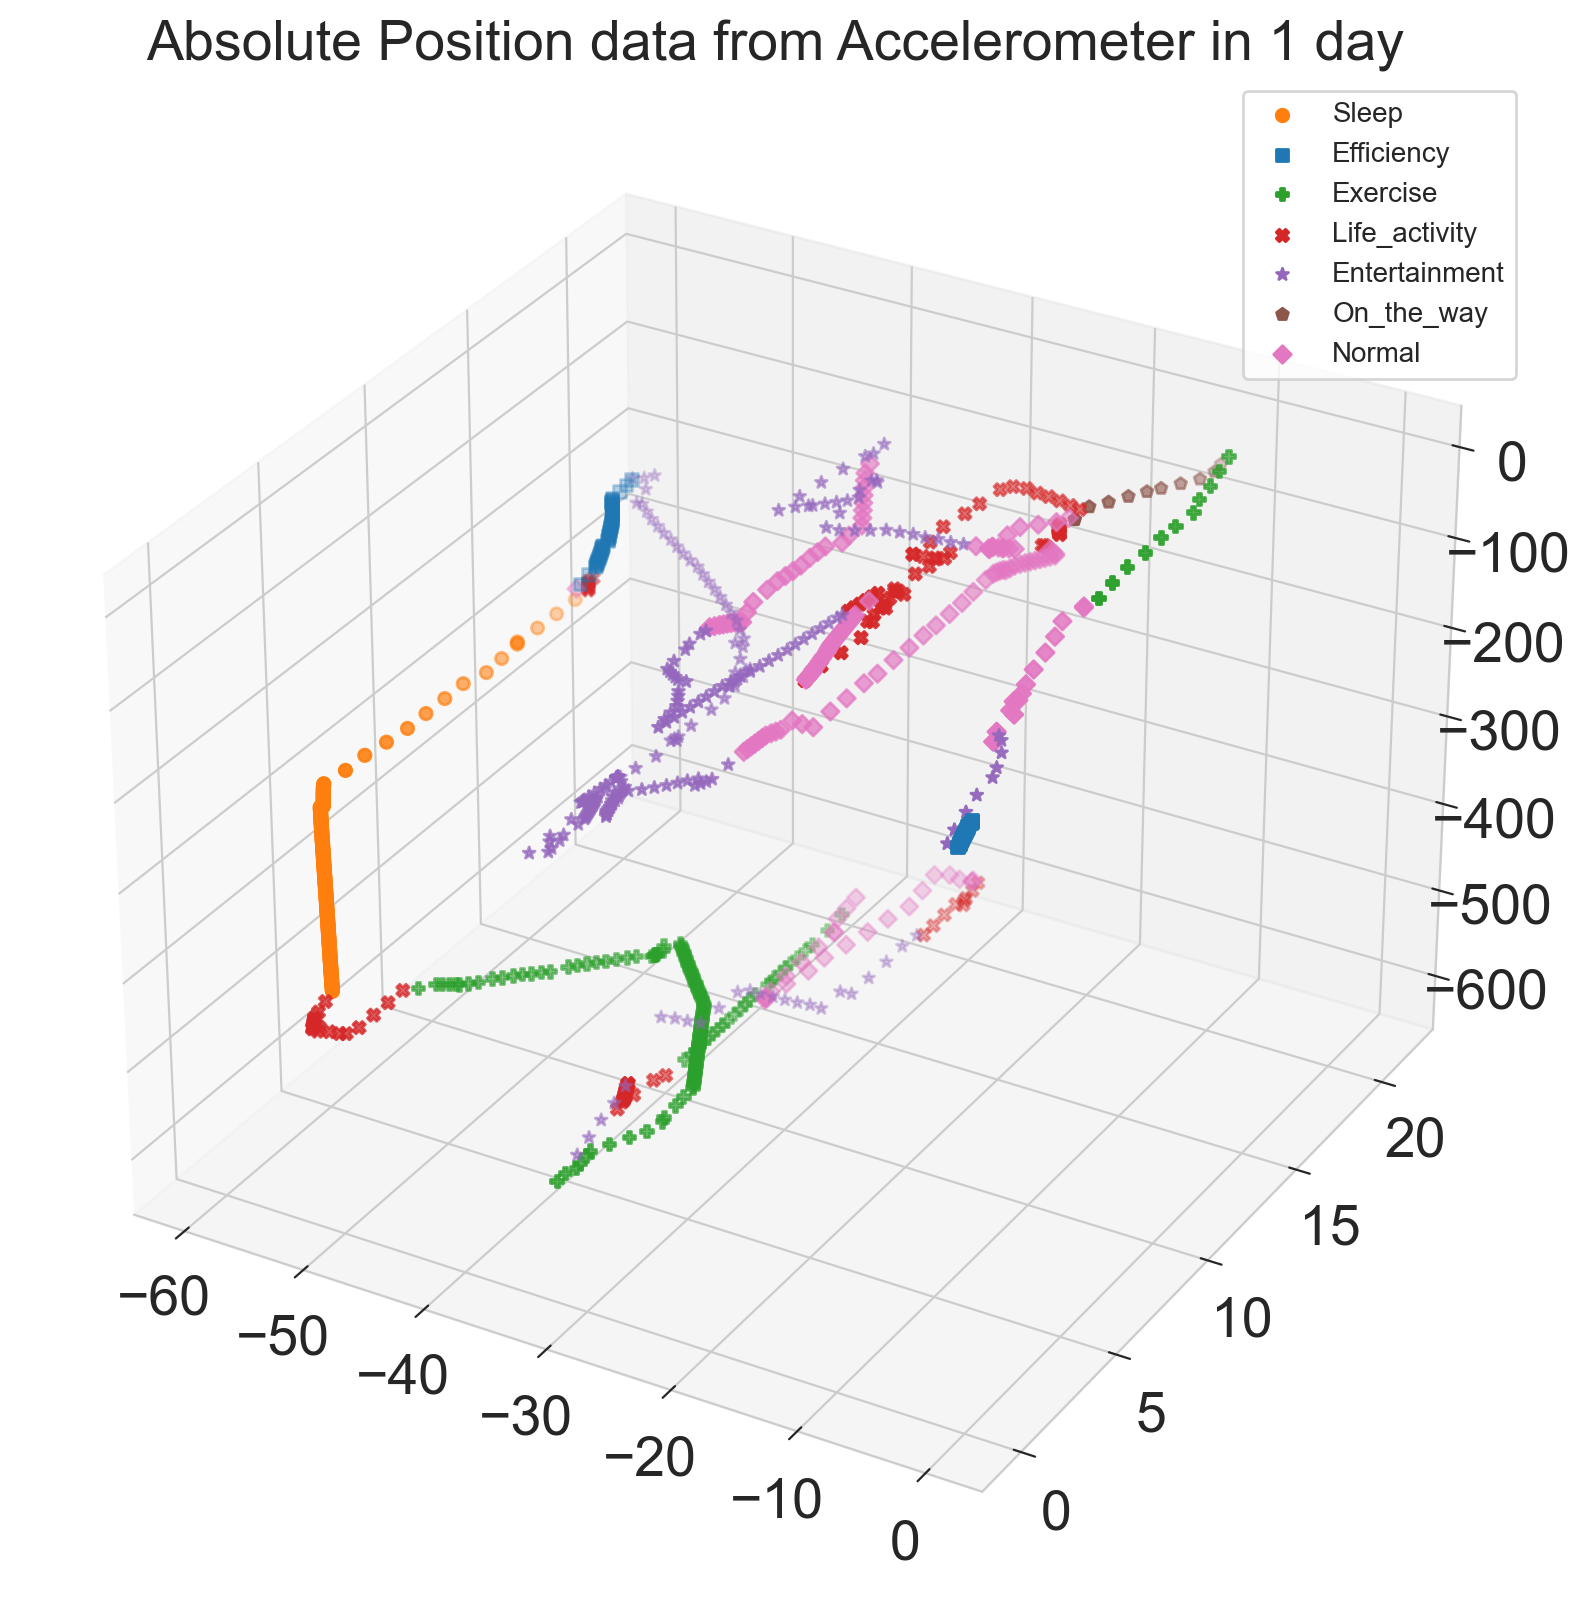

In [19]:
def get_sum_list(slice_df):
    to_list = list(slice_df)
    for i in range(len(to_list)):
        to_list[0] = 0
        to_list[i] = to_list[i-1] + to_list[i]
    return to_list

uuid_data = data.loc[uuid].iloc[:1000,:]
acc = uuid_data.iloc[:,1:4]
label = uuid_data.iloc[:,-1]
label_type = uuid_data.iloc[:,-1].value_counts().index


for i in range(3):
    acc.iloc[:,i] = get_sum_list(acc.iloc[:,i])

new_label_dict = {0:'Sleep', 1:'Efficiency', 2:'Exercise', 3:'Life_activity', 4:'Entertainment', 5:'On_the_way', 6:'Normal'}
label = uuid_data.iloc[:,-1]
label_type = uuid_data.iloc[:,-1].value_counts().index

fig = plt.figure(figsize=(10,10),dpi=200)

colors = ['#ff7f0e','#1f77b4',  '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
markers = ['o','s','P','X','*','p','D']
ax2 = plt.axes(projection='3d')
for i in range(7):
    index = label[label.values == i].index
    ax2.scatter(acc.loc[index].iloc[:,0],acc.loc[index].iloc[:,1],acc.loc[index].iloc[:,2],c = colors[i],label=new_label_dict[i],marker=markers[i])
plt.rcParams.update({"font.size":10})
plt.legend(fontsize=10)
plt.title('Absolute Position data from Accelerometer in 1 day',fontsize=20)
plt.show()

### ADF test


In [20]:
with gzip.open('cleaned_data.zip','rb')as file:
    cleaned_data = pd.read_csv(file, index_col=[0,1])

cleaned_uuid = []
for i in cleaned_data.index:
    cleaned_uuid.append(i[0])
cleaned_uuid = list(set(cleaned_uuid))

In [21]:
from statsmodels.tsa.stattools import adfuller

uuid_nan = pd.DataFrame(
  columns = cleaned_data.columns,
  index = cleaned_uuid
)

uuid_stationary = pd.DataFrame(
  columns = [x for x in cleaned_data.columns if 'discrete' not in x],
  index = cleaned_uuid
)


# Run all cleaned_uuid
for i in range(len(cleaned_uuid)):    
    temp_data = cleaned_data.loc[cleaned_uuid[i]]
    
    # Run all Main Feature
    for feature_name in cleaned_data.columns:
        # Create uuid_nan dataframe to check the number of missing values
        uuid_nan.loc[cleaned_uuid[i],feature_name] = np.isnan(temp_data[feature_name]).sum()
        
        # ADF Test without discrete feature
        if 'discrete' not in feature_name:            
            result = adfuller(temp_data[feature_name])

            # Create uuid_stationary dataframe to check stationary
            if result[1] < 0.05:
                uuid_stationary.loc[cleaned_uuid[i],feature_name] = "Stationary"
            else:
                uuid_stationary.loc[cleaned_uuid[i],feature_name] = "False"

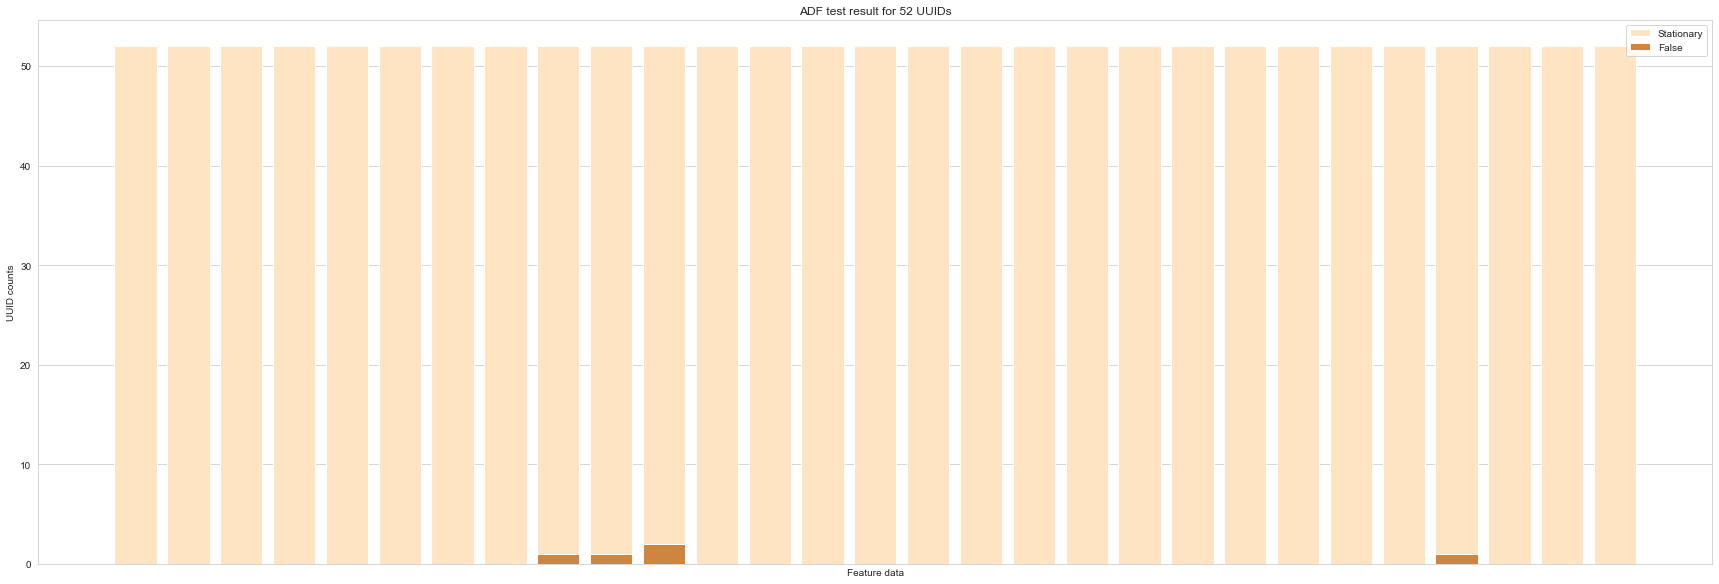

In [22]:
counts = uuid_stationary.apply(pd.Series.value_counts)
counts = counts.fillna(0)
# create bar plot
fig, ax = plt.subplots(figsize=(30, 10))
plt.bar(counts.columns, counts.iloc[1,:]+counts.iloc[0,:],color = 'bisque')
plt.bar(range(len(counts.columns)), counts.iloc[0,:],color = 'peru')

# plt.xticks(range(len(counts.columns)), counts.columns,rotation=90)
plt.xticks([])
plt.title('ADF test result for 52 UUIDs')
plt.legend(['Stationary','False'])
plt.xlabel('Feature data')
plt.ylabel('UUID counts')
plt.show()